# XGBoost Optimization for Bankruptcy Prediction

**Objective:** Train and optimize XGBoost with focus on imbalanced data

**Key Features:**
- `scale_pos_weight` for class imbalance
- Randomized hyperparameter search
- Feature importance analysis
- Comparison with best techniques from Notebook 01

In [1]:
import os

In [2]:
# Setup
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

from data_loader import BankruptcyDataLoader
from imbalance_techniques import ImbalanceHandler
from evaluation import ModelEvaluator
from models import BankruptcyModelTrainer

sns.set_style('whitegrid')
print("✓ Libraries imported!")

✓ Libraries imported!


## 1. Load Data

In [3]:
DATA_PATH = r'/Users/ritwikreddy/Desktop/check_bankruptcy/polish+companies+bankruptcy+data'
loader = BankruptcyDataLoader(DATA_PATH)
X_train, X_test, y_train, y_test = loader.prepare_data()

# Calculate class imbalance ratio
ratio = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nClass imbalance ratio: {ratio:.2f}")
print(f"Recommended scale_pos_weight: {ratio:.2f}")

BANKRUPTCY DATA PREPARATION PIPELINE
✓ Loaded 1year.arff: (7027, 65)
✓ Loaded 2year.arff: (10173, 65)
✓ Loaded 3year.arff: (10503, 65)
✓ Loaded 4year.arff: (9792, 65)
✓ Loaded 5year.arff: (5910, 65)

✓ Combined dataset shape: (43405, 65)

Features shape: (43405, 64)
Target shape: (43405,)
Class distribution:
class
0    41314
1     2091
Name: count, dtype: int64
Imbalance ratio: 0.0506

=== Train-Test Split ===
Train set: 34724 samples
Test set: 8681 samples

=== Handling Missing Values ===
Columns with missing values: 64
  - Dropping columns (>5.0% missing): 3
  - Imputing columns: 61
✓ Final shapes - Train: (34724, 61), Test: (8681, 61)

=== Feature Scaling ===
✓ Scaling completed
  Train mean: 0.000000
  Train std: 1.000014

✓ DATA PREPARATION COMPLETE

Class imbalance ratio: 19.76
Recommended scale_pos_weight: 19.76


## 2. Baseline XGBoost

In [4]:
evaluator = ModelEvaluator(cost_fp=5000, cost_fn=100000)

# Baseline with scale_pos_weight
print("Training baseline XGBoost...")
xgb_baseline = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=ratio,
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
)

xgb_baseline.fit(X_train, y_train)
y_pred = xgb_baseline.predict(X_test)
y_prob = xgb_baseline.predict_proba(X_test)[:, 1]

baseline_metrics = evaluator.print_evaluation(y_test, y_pred, y_prob, "XGBoost Baseline")

Training baseline XGBoost...

XGBoost Baseline - EVALUATION REPORT

📊 Classification Metrics:
  Accuracy:  0.9198
  Precision: 0.3420 (of predicted bankruptcies, how many are correct)
  Recall:    0.7201 (of actual bankruptcies, how many we catch)
  F1-Score:  0.4638 (harmonic mean of precision & recall)

📈 Probability-based Metrics:
  ROC-AUC:   0.9313
  PR-AUC:    0.5676 (better for imbalanced data)

💰 Business Metrics:
  Total Cost:     $14,595,000.00
  Avg Cost/Sample: $1681.26
  (FP cost: $5000, FN cost: $100000)

🎯 Confusion Matrix:
                Predicted Negative  Predicted Positive
  Actual Negative        7684 (TN)           579 (FP)
  Actual Positive         117 (FN)           301 (TP)

📋 Classification Report:
              precision    recall  f1-score   support

           0     0.9850    0.9299    0.9567      8263
           1     0.3420    0.7201    0.4638       418

    accuracy                         0.9198      8681
   macro avg     0.6635    0.8250    0.7102     

## 3. Hyperparameter Tuning

In [5]:
print("\nStarting randomized search (this will take 10-15 minutes)...")

param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'scale_pos_weight': [ratio * 0.5, ratio, ratio * 1.5, ratio * 2]
}

xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions,
    n_iter=50,
    scoring='f1',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print(f"\n✓ Best F1 score: {random_search.best_score_:.4f}")
print("\nBest parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

# Save best model
import joblib
os.makedirs('../api/models', exist_ok=True)
joblib.dump(random_search.best_estimator_, '../api/models/xgb_tuned.pkl')
print("\n✓ Best model saved to ../api/models/xgb_tuned.pkl")


Starting randomized search (this will take 10-15 minutes)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits



✓ Best F1 score: 0.5596

Best parameters:
  subsample: 0.8
  scale_pos_weight: 29.63329348475792
  n_estimators: 500
  min_child_weight: 5
  max_depth: 7
  learning_rate: 0.05
  gamma: 0
  colsample_bytree: 0.9

✓ Best model saved to ../api/models/xgb_tuned.pkl


## 4. Evaluate Tuned Model

In [6]:
xgb_tuned = random_search.best_estimator_

y_pred_tuned = xgb_tuned.predict(X_test)
y_prob_tuned = xgb_tuned.predict_proba(X_test)[:, 1]

tuned_metrics = evaluator.print_evaluation(y_test, y_pred_tuned, y_prob_tuned, "XGBoost Tuned")

# Compare
print("\n" + "="*80)
print("IMPROVEMENT")
print("="*80)
for metric in ['f1_score', 'recall', 'precision', 'pr_auc']:
    baseline_val = baseline_metrics[metric]
    tuned_val = tuned_metrics[metric]
    improvement = ((tuned_val - baseline_val) / baseline_val * 100) if baseline_val > 0 else 0
    print(f"{metric:15s}: {baseline_val:.4f} → {tuned_val:.4f} ({improvement:+.2f}%)")


XGBoost Tuned - EVALUATION REPORT

📊 Classification Metrics:
  Accuracy:  0.9596
  Precision: 0.5792 (of predicted bankruptcies, how many are correct)
  Recall:    0.5861 (of actual bankruptcies, how many we catch)
  F1-Score:  0.5826 (harmonic mean of precision & recall)

📈 Probability-based Metrics:
  ROC-AUC:   0.9425
  PR-AUC:    0.6200 (better for imbalanced data)

💰 Business Metrics:
  Total Cost:     $18,190,000.00
  Avg Cost/Sample: $2095.38
  (FP cost: $5000, FN cost: $100000)

🎯 Confusion Matrix:
                Predicted Negative  Predicted Positive
  Actual Negative        8085 (TN)           178 (FP)
  Actual Positive         173 (FN)           245 (TP)

📋 Classification Report:
              precision    recall  f1-score   support

           0     0.9791    0.9785    0.9788      8263
           1     0.5792    0.5861    0.5826       418

    accuracy                         0.9596      8681
   macro avg     0.7791    0.7823    0.7807      8681
weighted avg     0.9598   

## 5. Feature Importance

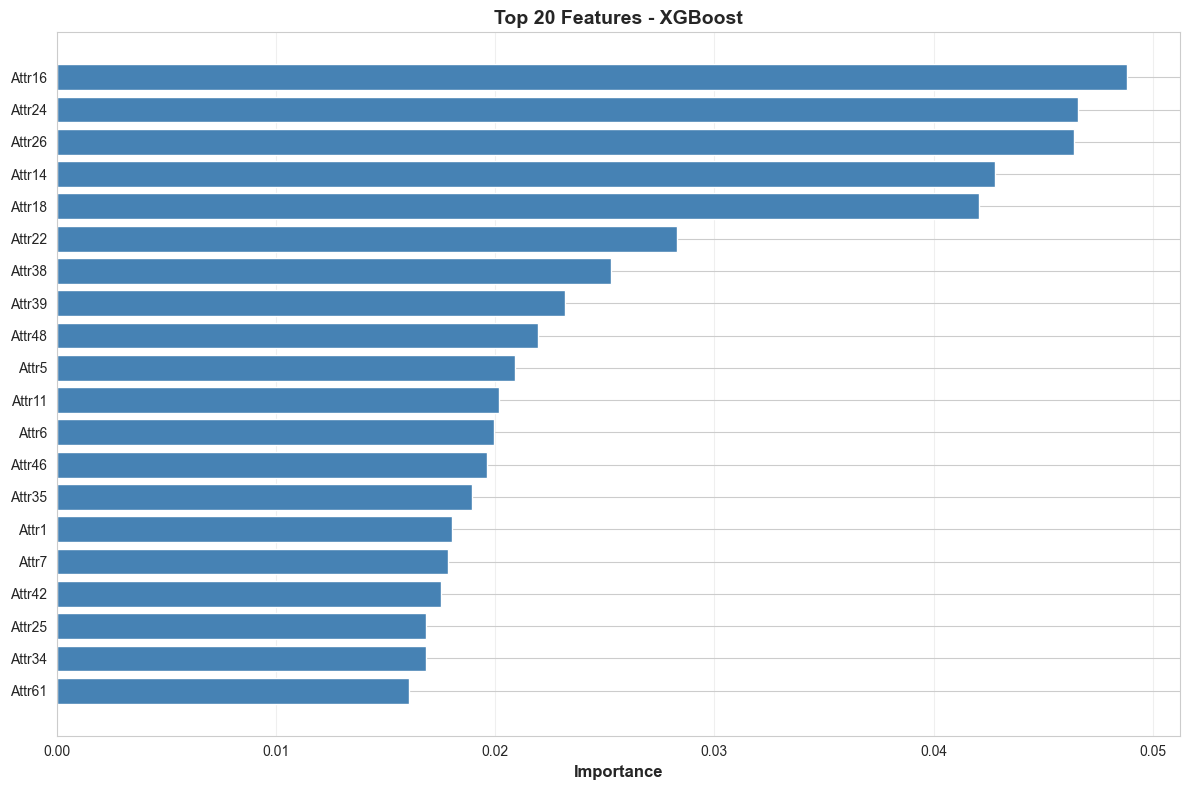

✓ Saved to ../figures/02_xgb_feature_importance.png


In [7]:
import shap

# Get feature importance
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_tuned.feature_importances_
}).sort_values('importance', ascending=False).head(20)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(len(importance_df)), importance_df['importance'].values, color='steelblue')
ax.set_yticks(range(len(importance_df)))
ax.set_yticklabels(importance_df['feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Features - XGBoost', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../figures/02_xgb_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved to ../figures/02_xgb_feature_importance.png")

## 6. Test with SMOTE

In [12]:
from imblearn.over_sampling import SMOTE

print("Testing XGBoost + SMOTE combination...")

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

xgb_smote = XGBClassifier(**random_search.best_params_, random_state=42, n_jobs=-1)
xgb_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = xgb_smote.predict(X_test)
y_prob_smote = xgb_smote.predict_proba(X_test)[:, 1]

smote_metrics = evaluator.print_evaluation(y_test, y_pred_smote, y_prob_smote, "XGBoost + SMOTE")

# Save this model too
joblib.dump(xgb_smote, '../api/models/xgb_smote.pkl')
print("\n✓ Saved to ../api/models/xgb_smote.pkl")

Testing XGBoost + SMOTE combination...

XGBoost + SMOTE - EVALUATION REPORT

📊 Classification Metrics:
  Accuracy:  0.8863
  Precision: 0.2707 (of predicted bankruptcies, how many are correct)
  Recall:    0.8038 (of actual bankruptcies, how many we catch)
  F1-Score:  0.4051 (harmonic mean of precision & recall)

📈 Probability-based Metrics:
  ROC-AUC:   0.9302
  PR-AUC:    0.5806 (better for imbalanced data)

💰 Business Metrics:
  Total Cost:     $12,725,000.00
  Avg Cost/Sample: $1465.84
  (FP cost: $5000, FN cost: $100000)

🎯 Confusion Matrix:
                Predicted Negative  Predicted Positive
  Actual Negative        7358 (TN)           905 (FP)
  Actual Positive          82 (FN)           336 (TP)

📋 Classification Report:
              precision    recall  f1-score   support

           0     0.9890    0.8905    0.9371      8263
           1     0.2707    0.8038    0.4051       418

    accuracy                         0.8863      8681
   macro avg     0.6299    0.8472    0.

## 7. Summary & Next Steps

In [13]:
# Create comparison
comparison = pd.DataFrame([
    {'Configuration': 'XGBoost Baseline', **baseline_metrics},
    {'Configuration': 'XGBoost Tuned', **tuned_metrics},
    {'Configuration': 'XGBoost + SMOTE', **smote_metrics}
])

print("\n" + "="*80)
print("FINAL COMPARISON")
print("="*80)
print(comparison[['Configuration', 'f1_score', 'precision', 'recall', 'pr_auc', 'total_cost']].round(4).to_string(index=False))

comparison.to_csv('../results/xgboost_results.csv', index=False)

print("\n✓ Next: Threshold optimization and calibration!")
print("="*80)


FINAL COMPARISON
   Configuration  f1_score  precision  recall  pr_auc  total_cost
XGBoost Baseline    0.4638     0.3420  0.7201  0.5676    14595000
   XGBoost Tuned    0.5826     0.5792  0.5861  0.6200    18190000
 XGBoost + SMOTE    0.4051     0.2707  0.8038  0.5806    12725000

✓ Next: Threshold optimization and calibration!
